### Here we test making grid property plots for individual objects.
- star - gas offsets
- BH luminosity
- BH energy injected
- angular momentum / circularity / kappa (i.e. ordered rotation)
- sSFR

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import kin_morph_funcs as knf
from astropy.cosmology import Planck15

In [2]:
path = '/Users/cd201/morphology_misalignment/catalogues/'

# loading in AGN info catalogue.
mass_tab = pd.read_csv('/Users/cd201/projects/bh_star_gas_misalignment/popeye/catalogues/'+'tng100_bh_history.csv')

# Need to add in mass history to angular momentum table.
ang_tab = pd.read_csv(path+'tng_mpl8_ang_mom_history.csv')

# merging mass and ang mom tables.
merged_tab = mass_tab.merge(ang_tab, left_on=['root_subfind', 'branch_snapnum'], right_on=['root_subfind', 'branch_snapnum'])

In [39]:
# using eyeballed classifications to select subhalo.
tng100_main = pd.read_csv(path+'tng100_mpl8_pa_info_v0.1_z0_info.csv', comment='#')
tng100_pa = knf.tng100_pa_sample(tng100_main)
sel = tng100_pa.subfind_id.values[tng100_pa.pa_offset > 160]

In [4]:
merged_tab.columns

Index(['branch_subfind_x', 'branch_snapnum', 'root_subfind', 'root_snap',
       'halo_mass', 'subhalo_mass', 'central_flag', 'stel_mass', 'gas_mass',
       'BH_mass', 'BH_Mdot', 'SFR', 'log10_Lbh_bol', 'log10_Lbh_xray',
       'BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM', 'BH_CumMassGrowth_QM',
       'BH_CumMassGrowth_RM', 'BH_local_gas_density', 'BHpart_count',
       'BH_progenitors', 'GasMetallicity', 'branch_z', 'Unnamed: 0',
       'branch_subfind_y', 'gas_DM_2d', 'gas_DM_3d', 'mag_sJ_DM', 'mag_sJ_gas',
       'mag_sJ_stel', 'root_snapnum', 'stel_DM_2d', 'stel_DM_3d',
       'stel_gas_2d', 'stel_gas_3d'],
      dtype='object')

In [33]:
def combine_with_tree_split_on_pa_and_mass(tab, tree_tab, PA=30, mass=None):
    '''
    Function that takes a defined sample in the TNG100 - MPL-8 matched population, combines
    with supplementary tree info (for the main branch) and then splits on both PA and mass 
    of the object at z=0.
    By default the median mass for the complete sample is used.
    Returns 6 tables; total info, aligned and misaligned for high mass and low mass.
    ''' 
    # combining with tree_tab since this is where mass info is stored.
    snap99_info = tree_tab[tree_tab.branch_snapnum == 99]
    tab_info = snap99_info[snap99_info.root_subfind.isin(tab.subfind_id.values)]
    # merging to include pa info.
    tab_info = tab_info.merge(tab, left_on=['root_subfind'], right_on=['subfind_id'])
    
    if mass is None:
        # if mass undefined, splitting on median.
        mass = np.median(tab_info.stel_mass.values)
    
    high_mass_all_tab = tree_tab[tree_tab.root_subfind.isin(tab_info.root_subfind.values[tab_info.stel_mass.values > mass])]
    high_mass_align_tab = tree_tab[tree_tab.root_subfind.isin(tab_info.root_subfind.values[(tab_info.pa_offset.values < PA) & (tab_info.stel_mass.values > mass)])]
    high_mass_mis_tab = tree_tab[tree_tab.root_subfind.isin(tab_info.root_subfind.values[(tab_info.pa_offset.values >= PA) & (tab_info.stel_mass.values > mass)] )]
    
    low_mass_all_tab = tree_tab[tree_tab.root_subfind.isin(tab_info.root_subfind.values[tab_info.stel_mass.values <= mass])]
    low_mass_align_tab = tree_tab[tree_tab.root_subfind.isin(tab_info.root_subfind.values[(tab_info.pa_offset.values < PA) & (tab_info.stel_mass.values <= mass)])]
    low_mass_mis_tab = tree_tab[tree_tab.root_subfind.isin(tab_info.root_subfind.values[(tab_info.pa_offset.values >= PA) & (tab_info.stel_mass.values <= mass)] )]
    
    return high_mass_all_tab, high_mass_align_tab, high_mass_mis_tab, low_mass_all_tab, low_mass_align_tab, low_mass_mis_tab


In [35]:
snap99_info = mass_tab[mass_tab.branch_snapnum == 99]
tab_info = snap99_info[snap99_info.root_subfind.isin(tng100_pa.subfind_id.values)]
tab_info = tab_info.merge(tng100_pa, left_on=['root_subfind'], right_on=['subfind_id'])

In [41]:
tng100_pa.columns

Index(['Unnamed: 0', 'BHMdot', 'BHmass', 'central_flag', 'exsitu',
       'exsitu_flyby', 'exsitu_major_mergers', 'exsitu_minor_mergers',
       'exsitu_outside_galaxies', 'gas_mass', 'halo_mass', 'insitu', 'radius',
       'sfms_flag', 'stel_mass', 'subfind_id', 'Unnamed: 0.1', 'ID', 'mangaid',
       'ifusize', 'redshift', 'lambda_r', 'star_axis', 'gas_axis', 'pa_offset',
       'stel_qual', 'stel_feature', 'halpha_qual', 'halpha_feature'],
      dtype='object')

In [5]:
# selecting a single subhalo.

def return_individual_params(subfind_id):
    mask = (merged_tab.root_subfind.values == subfind_id)
    return merged_tab[mask]

In [6]:
# adding column of lookback times.

merged_tab['branch_lookback_time'] = Planck15.lookback_time(merged_tab.branch_z.values).value

In [7]:
def instantaneous_energy_output(single_tab):
    cumsum_energy = - single_tab.BH_CumEgyInjection_QM.diff()[1:] + single_tab.BH_CumEgyInjection_RM.diff()[1:]
    return cumsum_energy / (single_tab.branch_lookback_time.diff()[1:] * 10**9)

def instantaneous_mass_growth(single_tab):
    cumsum_mass = - single_tab.BH_CumMassGrowth_QM.diff()[1:] + single_tab.BH_CumMassGrowth_RM.diff()[1:]
    return cumsum_mass / (single_tab.branch_lookback_time.diff()[1:] * 10**9)

def instantaneous_allmass_growth(column):
    return - column.diff()[1:] / (single_tab.branch_lookback_time.diff()[1:])

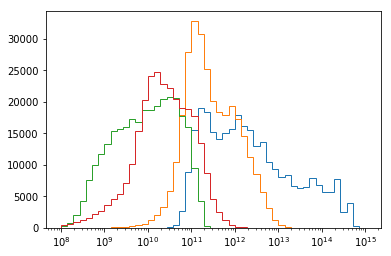

In [8]:
bins = np.logspace(8, 15)

fig = plt.figure()

plt.hist(merged_tab.halo_mass.values, bins=bins, histtype='step')
plt.hist(merged_tab.subhalo_mass.values, bins=bins, histtype='step')
plt.hist(merged_tab.stel_mass.values, bins=bins, histtype='step')
plt.hist(merged_tab.gas_mass.values, bins=bins, histtype='step')

plt.xscale('log')
plt.show()

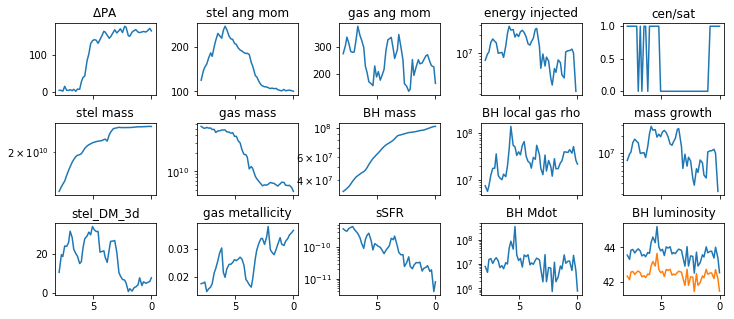

In [10]:
single_tab = return_individual_params(590890)

fig, ax = plt.subplots(3,5, figsize=(12, 5), sharex='all')
ax[0,0].set_title(r'$\Delta$PA')
ax[0,0].plot(single_tab.branch_lookback_time.values, single_tab.stel_gas_3d.values)
#ax[0,0].plot(single_tab.branch_lookback_time.values, single_tab.stel_gas_2d.values)

ax[0,1].set_title(r'stel ang mom')
ax[0,1].plot(single_tab.branch_lookback_time.values, single_tab.mag_sJ_stel.values)
#ax[0,1].plot(single_tab.branch_z.values, single_tab.mag_sJ_DM.values)

ax[0,2].set_title(r'gas ang mom')
ax[0,2].plot(single_tab.branch_lookback_time.values, single_tab.mag_sJ_gas.values)

ax[1,0].set_title(r'stel mass')
ax[1,0].plot(single_tab.branch_lookback_time.values, single_tab.stel_mass.values, label='stel')
ax[1,0].set_yscale('log')

ax[1,1].set_title(r'gas mass')
ax[1,1].plot(single_tab.branch_lookback_time.values, single_tab.gas_mass.values, label='gas')
ax[1,1].set_yscale('log')

ax[1,2].set_title('BH mass')
ax[1,2].plot(single_tab.branch_lookback_time.values, single_tab.BH_mass.values)
ax[1,2].set_yscale('log')

ax[2,0].set_title('stel_DM_3d')
ax[2,0].plot(single_tab.branch_lookback_time.values, single_tab.stel_DM_3d.values )

ax[2,1].set_title(r'gas metallicity')
ax[2,1].plot(single_tab.branch_lookback_time.values, single_tab.GasMetallicity.values)

ax[2,2].set_title(r'sSFR')
ax[2,2].plot(single_tab.branch_lookback_time.values, single_tab.SFR.values / single_tab.stel_mass.values )
ax[2,2].set_yscale('log')

ax[0,3].set_title('energy injected') 
ax[0,3].plot(single_tab.branch_lookback_time.values[1:], instantaneous_energy_output(single_tab) )
ax[0,3].set_yscale('log')

ax[1,3].set_title('BH local gas rho')
ax[1,3].plot(single_tab.branch_lookback_time.values, single_tab.BH_local_gas_density.values )
ax[1,3].set_yscale('log')

ax[2,3].set_title('BH Mdot')
ax[2,3].plot(single_tab.branch_lookback_time.values, single_tab.BH_Mdot.values )
ax[2,3].set_yscale('log')

ax[0,4].set_title('cen/sat')
ax[0,4].plot(single_tab.branch_lookback_time.values, single_tab.central_flag )

ax[1,4].set_title('mass growth')
ax[1,4].plot(single_tab.branch_lookback_time.values[1:], instantaneous_energy_output(single_tab) )
ax[1,4].set_yscale('log')

ax[2,4].set_title('BH luminosity')
ax[2,4].plot(single_tab.branch_lookback_time.values, single_tab.log10_Lbh_bol.values)
ax[2,4].plot(single_tab.branch_lookback_time.values, single_tab.log10_Lbh_xray.values)

ax[0,0].invert_xaxis()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [104]:
# list of possible case studies.
cases = np.array([261968, 322586, 612577, 642463, 236764, 358584, 175245, 617106, 614826, 242228, 493800, 352062, 601914, 466801])
lag_cases = np.array([527378])
no_bhlum_cases = np.array([273147, 286070, 493314, 538295, 322979])
long_mis_cases = np.array([249167, 555540, 502427, 204243, 433040, 445568, 200805])
merger_cases = np.array([557675, 424803])

In [ ]:
np.array([445568, 249167, 557675])

counter_rots = np.array([200805, 590890])